# Module 5 - Spooky Authorship Identification
#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

<hr>

### Objective
1) Accurately identify the author of the sentences in the test set
2) Perform all work with Apache Spark

<hr>

### Stage 0 - Import Data
1) Create a code notebook called: code_6_of_10_data_mine_group13.ipynb
2) Load the dataset into Spark data objects and explore structure, size, and distribution of information

In [2]:
# Stage 0 Solution
from pyspark.sql import SparkSession
import pandas as pd

# Start spark session and load train and test data sets
spark = SparkSession.builder.appName("Module_5_Project").getOrCreate()
df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

##### Summary

In [3]:
# Print size and descriptive statistics
print("==== DataSet Shape ====")
print(f"{len(df_train.columns)} columns\n{df_train.count()} rows\n")

print("==== DataSet Descriptive Statistics ====")
print(df_train.describe().show())

print("\n==== DataSet Unique Authors ====")
print(df_train.select('author').distinct().show())

==== DataSet Shape ====
3 columns
19579 rows

==== DataSet Descriptive Statistics ====
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

None

==== DataSet Unique Authors ====
+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+

None


<hr>

### Stage 1 - Data Preparation (Exploratory data analysis and text mining pre-processing)
1) Perform exploratory data analysis and create visualizations and tables as needed
2) Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data
    - Tokenize - split the text into individual words aka tokens.
    - Remove stop.words - frequently used pronouns and personal references.
        - Top ten include: I, you, he, she, it, we, they, me, him, her
    - Lemmatization - convert words to their root (optional).
        - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes

In [4]:
# Step 1 - Preprocessing
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, split, explode, length, lower, regexp_replace, count, row_number
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Get stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean and lowercase text, remove punctuation
df_train_cleaned = df_train.withColumn("clean_text", lower(regexp_replace(col("text"), r"[^a-zA-Z0-9\s]", "")))

# Tokenize into words then filter out empty strings after tokenization
df_train_words = df_train_cleaned.withColumn("word", explode(split(col("clean_text"), r"\s+"))).filter(col('word') != "")

# Remove stop words
df_train_filtered = df_train_words.filter(~col("word").isin(stop_words))

df_train_filtered.show(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Claud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+-------+--------------------+------+--------------------+------------+
|     id|                text|author|          clean_text|        word|
+-------+--------------------+------+--------------------+------------+
|id26305|This process, how...|   EAP|this process howe...|     process|
|id26305|This process, how...|   EAP|this process howe...|     however|
|id26305|This process, how...|   EAP|this process howe...|    afforded|
|id26305|This process, how...|   EAP|this process howe...|       means|
|id26305|This process, how...|   EAP|this process howe...|ascertaining|
|id26305|This process, how...|   EAP|this process howe...|  dimensions|
|id26305|This process, how...|   EAP|this process howe...|     dungeon|
|id26305|This process, how...|   EAP|this process howe...|       might|
|id26305|This process, how...|   EAP|this process howe...|        make|
|id26305|This process, how...|   EAP|this process howe...|     circuit|
+-------+--------------------+------+--------------------+------

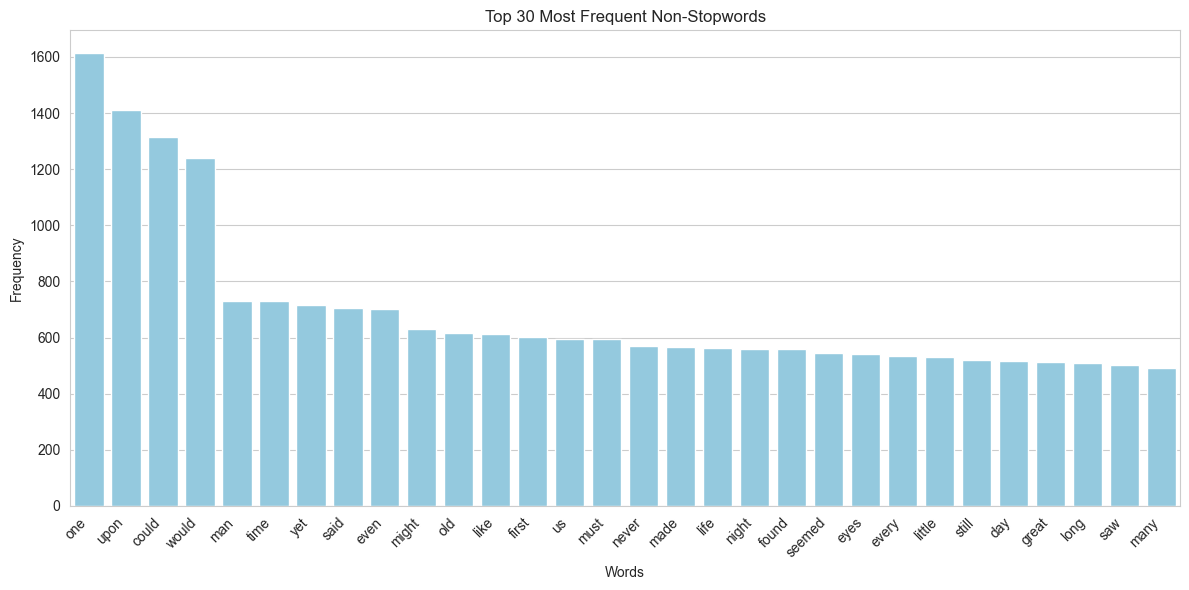

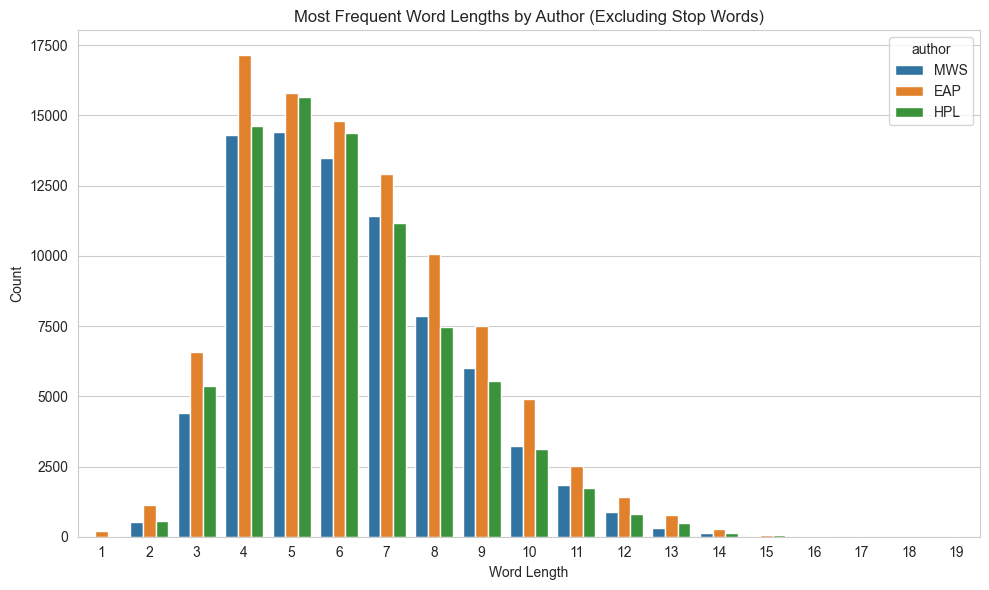

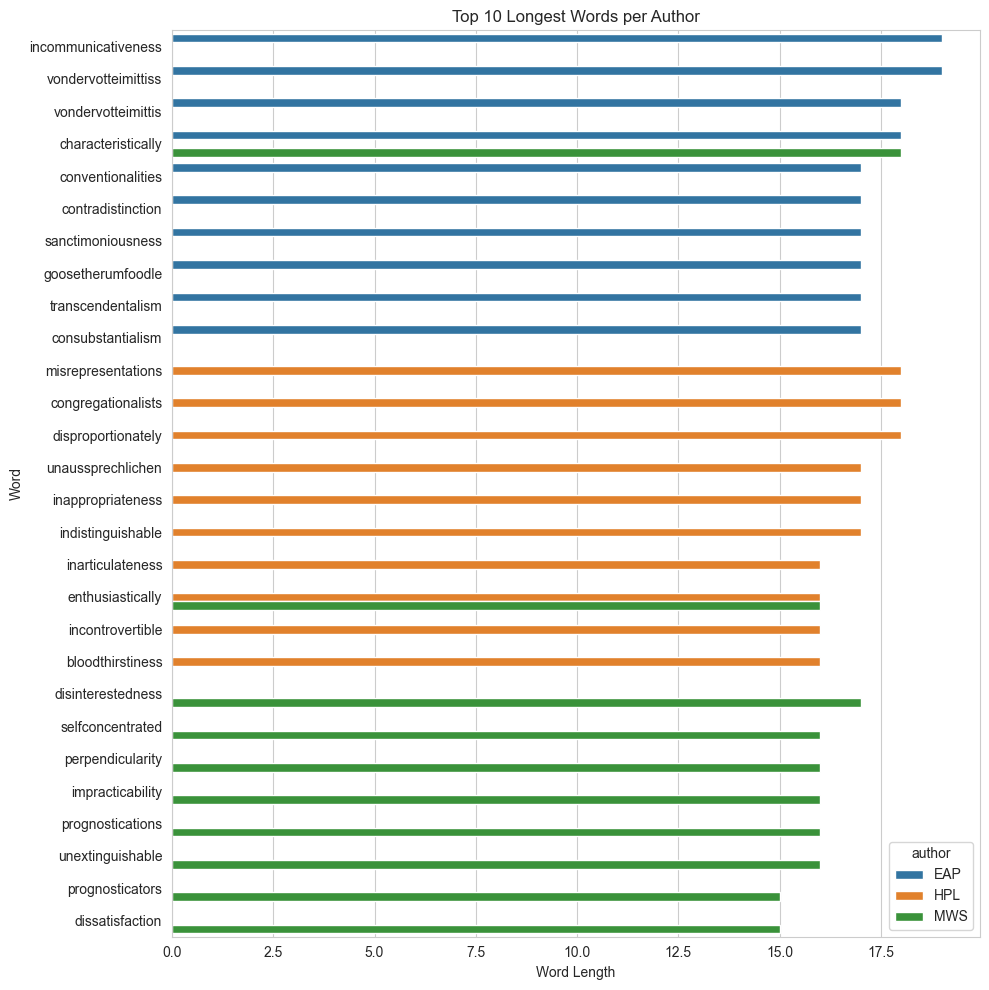

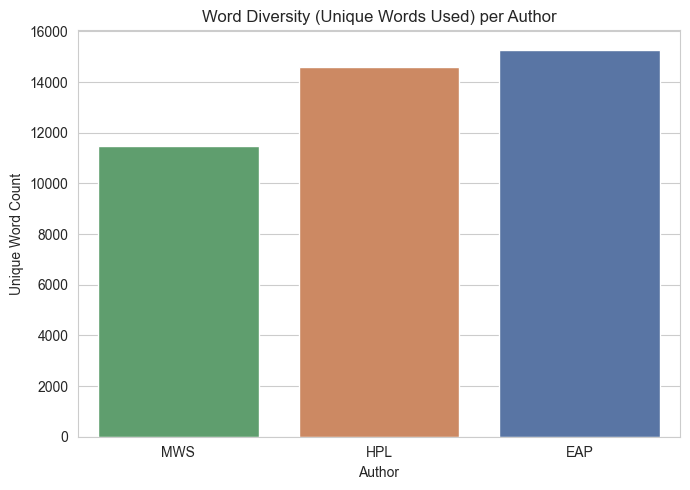

In [5]:
# Stage 1 Analysis and Visualizations
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ---------- CHART 1: Most Frequent Word Lengths ----------
# Get word frequency
df_word_freq = df_train_filtered.groupBy("word").agg(count("*").alias("frequency"))

# Get top 30 most frequent words
df_top_words = df_word_freq.orderBy(col("frequency").desc()).limit(30)

# Convert to pandas for sns
pdf_top_words = df_top_words.toPandas()

# Plot Chart 1
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_top_words, x="word", y="frequency", color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 30 Most Frequent Non-Stopwords")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---------- CHART 2: Most Frequent Word Lengths ----------
# Get word lengths
df_word_lengths = df_train_filtered.withColumn("length", length(col("word")))

# Group by author and length, then count occurrences
df_grouped = df_word_lengths.groupBy("author", "length").agg(count("*").alias("count"))

# Convert to pandas for sns
pdf_word_lengths = df_grouped.toPandas()

# Plot chart 2
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_word_lengths, x="length", y="count", hue="author")
plt.title("Most Frequent Word Lengths by Author (Excluding Stop Words)")
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- CHART 3: Top 10 Longest Words per Author ----------
# Group by author and word, get length of word
df_longest = df_word_lengths.groupBy("author", "word") \
    .agg(count("*").alias("count"),
    F.max(length(col('word'))).alias('length')
)

# Rank words by length within each author
windowSpec = Window.partitionBy("author").orderBy(col("length").desc())

# Get top 10 words per author
df_top_longest = df_longest.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= 10)

# Convert to pandas for sns
pdf_longest = df_top_longest.select("author", "word", "length").toPandas()

# Plot chart 3
plt.figure(figsize=(10, 10))
sns.barplot(data=pdf_longest, x="length", y="word", hue="author")
plt.title("Top 10 Longest Words per Author")
plt.xlabel("Word Length")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# ----- CHART 4: count unique words by author ----------
# Get unique words per author
df_unique_words = df_train_filtered.select("author", "word").distinct()

# Count the unique words per author
df_word_diversity = df_unique_words.groupBy("author").count().withColumnRenamed("count", "unique_word_count")

# Convert to pandas for sns
pdf_diversity = df_word_diversity.toPandas()

# Define custom color palette 
palette = {"EAP": "#4C72B0", "HPL": "#DD8452", "MWS": "#55A868"}

# Plot chart 4
plt.figure(figsize=(7, 5))
sns.barplot(data=pdf_diversity, x="author", y="unique_word_count", hue="author", palette=palette, legend=False)
plt.title("Word Diversity (Unique Words Used) per Author")
plt.xlabel("Author")
plt.ylabel("Unique Word Count")
plt.tight_layout()
plt.show()

<hr>

### Stage 2 - Feature Extraction
1) Perform TFIDF to quantify word importance <href><https://en.wikipedia.org/wiki/Tf%E2%80%93idf></href>
2) Normalize is scaling or standardizing the numerical features to a standard range or distribution
    - In text mining, normalization vectorizes features with methods like TFIDF, a numerical measurement, to ensure a consistent scale
    - It handles variations in the magnitude of feature values impacting machine-learning algorithm performance. Normalize the features to ensure a similar scale and prevent features with larger values from dominating the analysis or modeling process

In [13]:
# Stage 2 - TFIDF and Normalization 
from pyspark.sql.functions import col, collect_list, struct, first
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Normalizer
from pyspark.sql.types import StringType, ArrayType

# Aggregate words into list per id, author (currently they are a single field per row) and retain text column
df_grouped = df_train_filtered.groupBy("id", "author").agg(
    collect_list("word").alias("words"),
    first('clean_text').alias('clean_text')
)

# Compute HashingTF
hashingTF = HashingTF(inputCol='words', outputCol='tf', numFeatures=4096) # I selected 4096 for no particular reason, this can be tweaked.                           
tf_data_train = hashingTF.transform(df_grouped)

# Compute IDF
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=3)
idf_model_train = idf.fit(tf_data_train)
tfidf_data_train = idf_model_train.transform(tf_data_train)

# Normalize the data
normalizer = Normalizer(inputCol='tfidf', outputCol='tfidf_norm', p=2.0)
tfidf_data_train = normalizer.transform(tfidf_data_train)

# Drop unneeded columns and show a few rows
tfidf_data_train = tfidf_data_train.drop('tf', 'words')
tfidf_data_train.select('tfidf').show(truncate=False)

The data has this structure: `[Vector length], [indicies], [tf-idf values]`

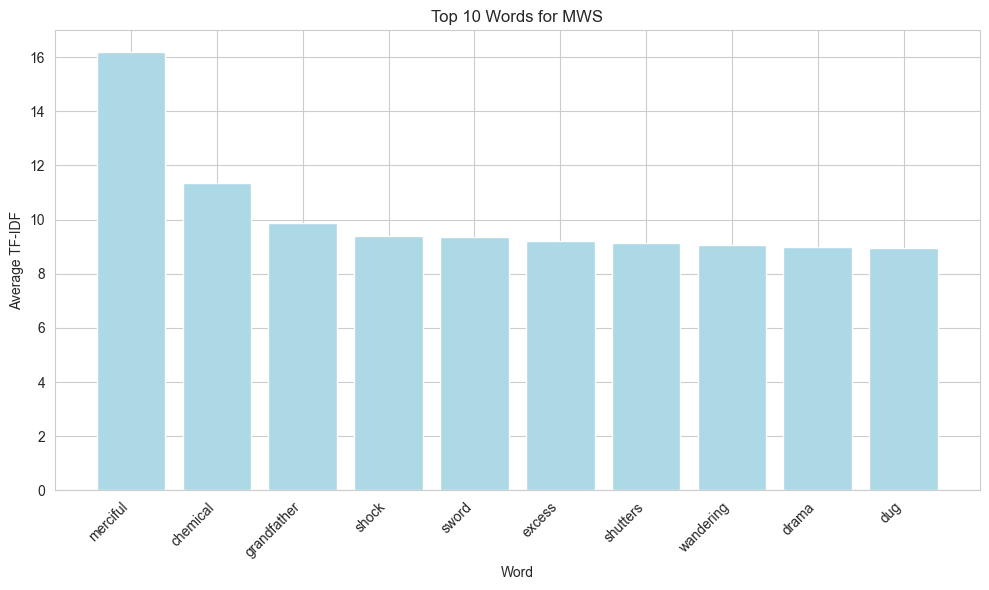

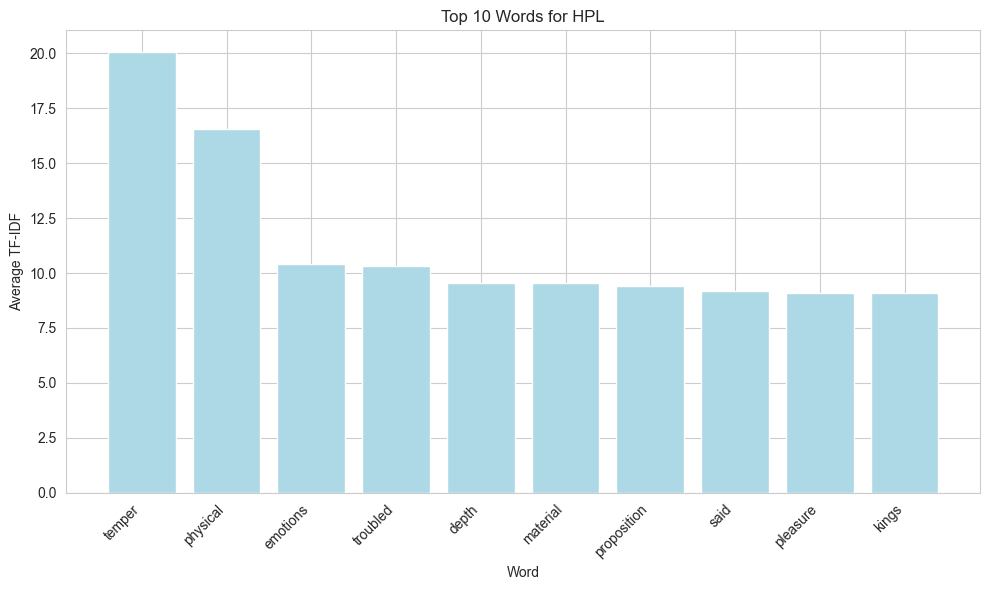

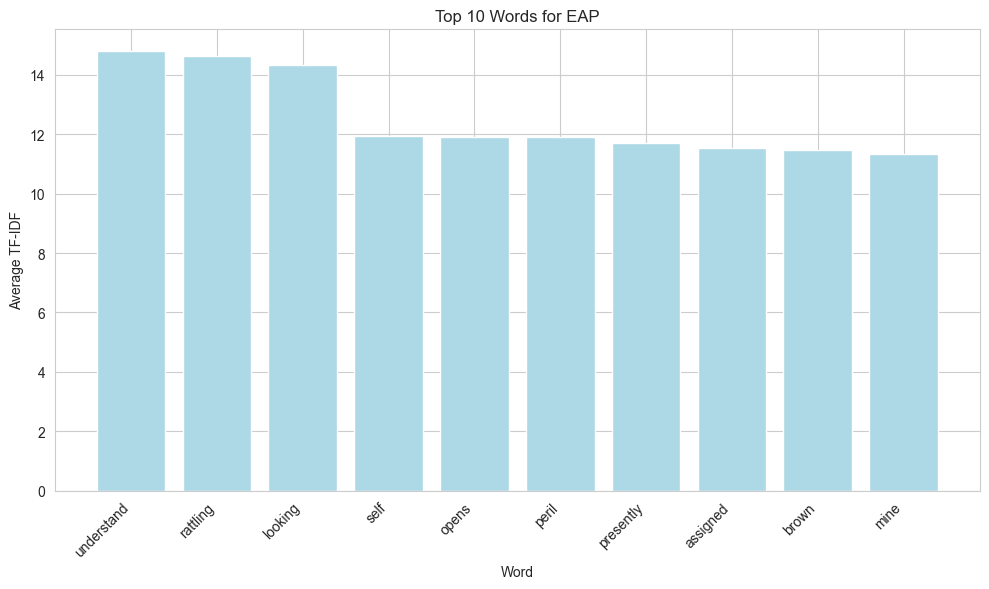

In [7]:
# Stage 2 Visualizations (ex: Most Important Word By Author)
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Redo TFIDF: Need to use CountVectorizer here to retain the words for future analysis
cv = CountVectorizer(inputCol='words', outputCol='tf_cv', minDF=3.0, vocabSize=4096)
cv_model = cv.fit(tf_data_train)
tf_cv_data = cv_model.transform(tf_data_train)
idf_cv = IDF(minDocFreq=3, inputCol='tf_cv', outputCol='tfidf')
idf_cv_model = idf.fit(tf_cv_data)
tfidf_cv_data = idf_cv_model.transform(tf_cv_data).drop('tf_cv')
tfidf_cv_data.cache()

# Here I have to switch to using Pandas, as Spark would have timeout issues when trying to parse the TFIDF dataframe. Since this is just for visualization this should be fine
tfidf_pandas = tfidf_cv_data.select('author', 'tfidf').toPandas()

# Group the tfidf vectors per author
top_words_per_author = defaultdict(list)
for _, row in tfidf_pandas.iterrows():
    author = row['author']
    vector = row['tfidf']
    for index, value in zip(vector.indices, vector.values):
        top_words_per_author[author].append((index, value))

# Now compute the average tfidf value per word per author
avg_tfidf_per_author = {}
vocab = cv_model.vocabulary
for author, terms in top_words_per_author.items():
    # For each term get the sum and counts
    index_sums = defaultdict(lambda: {'sum': 0.0, 'count': 0})
    for index, value in terms:
        index_sums[index]['sum'] += value
        index_sums[index]['count'] += 1
    
    # Now compute the averages
    avg_tfidf = [(vocab[index], data['sum'] / data['count']) for index, data in index_sums.items()]

    # Sort averages by descending average value (element 1 in avg_tfidf above) and get top 10 words
    avg_tfidf = sorted(avg_tfidf, key=lambda x: x[1], reverse=True)[:10]

    # Assign them to the correct author
    avg_tfidf_per_author[author] = pd.DataFrame(avg_tfidf, columns=['word', 'avg(value)'])

# Plot the best words per author
for author, df in avg_tfidf_per_author.items():
    plt.figure(figsize=(10, 6))
    plt.bar(df['word'], df['avg(value)'], color='lightblue')
    plt.xlabel('Word')
    plt.ylabel('Average TF-IDF')
    plt.title(f'Top 10 Words for {author}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<hr>

### Stage 3 - Machine Learning
1) Perform train/test split
2) Perform algorithmic analysis to assess and predict test labels
    - Use as many algorithms as you need to get a good answer.
    - Supervised: logistic regression, random forest, support vector machines, etc.
    - Unsupervised: K-means, dimensionality reduction, PCA, etc.

In [8]:
# Stage 3 Solution (Due by Monday 7/21)
# Each team member will do 2 algorithms of their choosing

# Train test split for below
train_data, test_data = tfidf_data_train.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()
print(f"Training set size: {train_data.count()} rows")
print(f"Test set size: {test_data.count()} rows")

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [9]:
# Aidan: Logistic Regression, Agglomerative Heirarchical Clustering

# ---------- Logistic Regression ----------
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)

# Train Logisitic Regression Model
lr = LogisticRegression(featuresCol='tfidf', labelCol='label', maxIter=1000, regParam=0.01)
lr_model = lr.fit(indexed_train)

# Predict test data and convert numerical labels back to authors
lr_predictions = lr_model.transform(indexed_test)

label_mapping = indexer_model.labels  # Get mapping of indices to author names (e.g., ['EAP', 'HPL', 'MWS'])
lr_predictions = lr_predictions.withColumn("predicted_author",
    col("prediction").cast("integer").cast("string"))  # Convert prediction to string
lr_predictions = lr_predictions.replace(
    to_replace={str(i): label_mapping[i] for i in range(len(label_mapping))},
    subset=["predicted_author"]
)

# Print top 5 predictions
print("---------------- Logistic Regression Predictions ----------------")
lr_predictions.select("clean_text", "author", "label", "prediction").show(5, truncate=False)

# ---------- Agglomerative Heirarchical Clustering (Using Bisecting KMeans) ----------
from pyspark.ml.clustering import BisectingKMeans

# Train the Bisecting KMeans model
bkm = BisectingKMeans(featuresCol='tfidf', k=3, seed=42)
bkm_model = bkm.fit(train_data)

# Cluster predictions on train and test data
bkm_train_predictions = bkm_model.transform(train_data)
bkm_test_predictions = bkm_model.transform(test_data)

# Show sample cluster assignments for training data
print("\n\n---------------- Train Data Cluster Assignments ----------------")
bkm_train_predictions.select("id", "clean_text", "author", "prediction").show(5, truncate=False)

# Show sample cluster assignments for test data
print("\n\n---------------- Test Data Cluster Assignments ----------------")
bkm_test_predictions.select("id", "clean_text", "prediction").show(5, truncate=False)

In [69]:
# Daniel: SVC, K-Means


In [41]:
# Claudine: Decision Tree and LDA in PySpark
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import LDA

# Use normalized TFIDF and correct DataFrame
data = tfidf_data_train.select("tfidf_norm", "author")

# Index labels
label_indexer = StringIndexer(inputCol="author", outputCol="label")
indexed_data = label_indexer.fit(data).transform(data)

# Split
train_data, test_data = indexed_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree with maxDepth
dt = DecisionTreeClassifier(featuresCol="tfidf_norm", labelCol="label", maxDepth=10)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# LDA Topic Modeling (still uses raw TFIDF)
lda = LDA(k=3, seed=42, featuresCol="tfidf")
lda_model = lda.fit(tfidf_data_train)
topics = lda_model.describeTopics(10)


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [40]:
# Claudine: Decision Tree (with CrossValidator) + LDA

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Prepare data
data = tfidf_data_train.select("tfidf_norm", "author")
label_indexer = StringIndexer(inputCol="author", outputCol="label")
indexed_data = label_indexer.fit(data).transform(data)

# Split
train_data, test_data = indexed_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree setup
dt = DecisionTreeClassifier(featuresCol="tfidf_norm", labelCol="label")

# Hyperparameter grid
param_grid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [10, 15, 20])
              .addGrid(dt.minInstancesPerNode, [1, 2])
              .build())

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Cross-validator
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=3)

# Fit the best model
cv_model = cv.fit(train_data)
dt_best_model = cv_model.bestModel
dt_predictions = dt_best_model.transform(test_data)

# LDA (Unsupervised)
lda = LDA(k=3, seed=42, featuresCol="tfidf_norm")
lda_model = lda.fit(tfidf_data_train)
topics = lda_model.describeTopics(10)
topics.show(truncate=False)


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [71]:
# Radhika: Random Forest, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)

# Train Random Forest Classifier Model
rf = RandomForestClassifier(featuresCol='tfidf', labelCol='label', numTrees=10)
rf_model = rf.fit(indexed_train)

# Predict test data and convert numerical labels back to authors
rf_predictions = rf_model.transform(indexed_test)

label_mapping = indexer_model.labels  # Get mapping of indices to author names (e.g., ['EAP', 'HPL', 'MWS'])
rf_predictions = rf_predictions.withColumn("predicted_author",
    col("prediction").cast("integer").cast("string"))  # Convert prediction to string
rf_predictions = rf_predictions.replace(
    to_replace={str(i): label_mapping[i] for i in range(len(label_mapping))},
    subset=["predicted_author"]
)

# Print top 5 predictions
print("---------------- Random Forest Predictions ----------------")
rf_predictions.select("clean_text", "author", "label", "prediction").show(5, truncate=False)


from pyspark.ml.feature import PCA

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)

# Apply PCA to reduce to 5 components
pca = PCA(k=5, inputCol='tfidf', outputCol='pca_features')
pca_model = pca.fit(indexed_train)

# Predict test data and convert numerical labels back to authors
train_pca = pca_model.transform(indexed_train)
pca_predictions = pca_model.transform(indexed_test)

label_mapping = indexer_model.labels  # Get mapping of indices to author names (e.g., ['EAP', 'HPL', 'MWS'])
pca_predictions = pca_predictions.withColumn("predicted_author",
    col("prediction").cast("integer").cast("string"))  # Convert prediction to string
pca_predictions = pca_predictions.replace(
    to_replace={str(i): label_mapping[i] for i in range(len(label_mapping))},
    subset=["predicted_author"]
)

# Print top 5 predictions
print("---------------- PCA Predictions ----------------")
train_pca.select("pca_features").show(5, truncate=False)
pca_predictions.select("clean_text", "author", "label", "prediction").show(5, truncate=False)

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

<hr>

### Stage 4 - Evaluation and Visualization
1) Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score
2) Visualize confusion matrix, correlations, and similar
3) Identify important features contributing to classification
4) Write a 2-3 sentence minimum of findings, learnings, and what you would do next

In [ ]:
# Stage 4 Solution (Due by Monday 7/21)
# Each team member will evaluate their models

Logistic Regression F1 Score: 0.6733586193041974


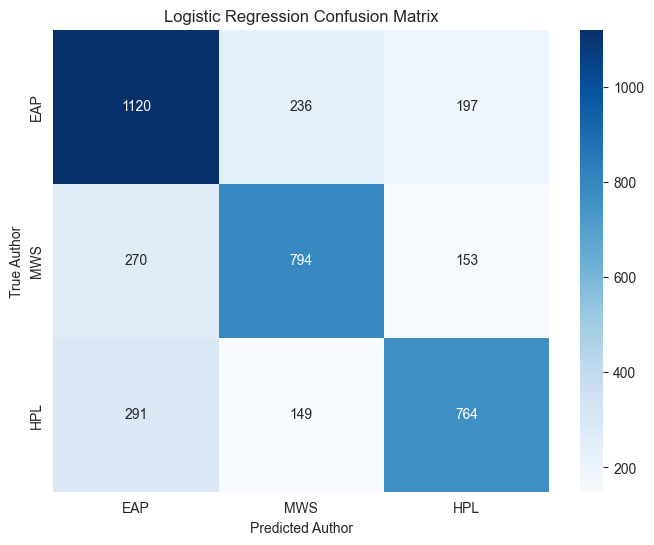

Bisecting K-Means Silhouette Score: -0.0224628774973654
+----------+------+-----+
|prediction|author|count|
+----------+------+-----+
|         0|   MWS| 2274|
|         1|   MWS| 1432|
|         2|   EAP| 1428|
|         2|   HPL| 1294|
|         0|   EAP| 3557|
|         0|   HPL| 1478|
|         2|   MWS| 1120|
|         1|   HPL| 1659|
|         1|   EAP| 1360|
+----------+------+-----+



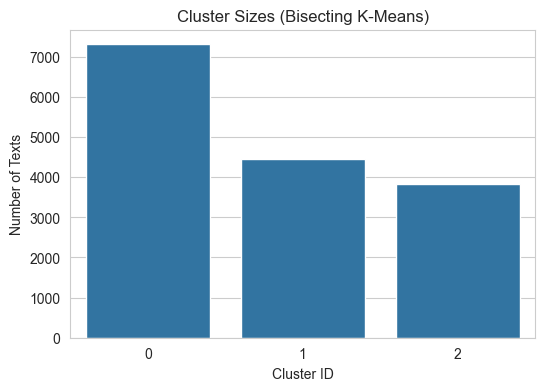

In [145]:
# Aidan
# ---------- Logistic Regression ----------
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {f1_score}")

# Get confusion matrix
df_lr_predictions = lr_predictions.select('label', 'prediction').toPandas()
conf_mat = confusion_matrix(df_lr_predictions['label'], df_lr_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()

# ---------- Agglomerative Heirarchical Clustering (Using Bisecting KMeans) ----------
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import count

# Calculate silhouette score
evaluator = ClusteringEvaluator(featuresCol='tfidf', predictionCol='prediction')
silhouette = evaluator.evaluate(bkm_train_predictions)
print(f"Bisecting K-Means Silhouette Score: {silhouette}")

# Map clusters to authors
cluster_author_counts = bkm_train_predictions.groupBy("prediction", "author").agg(count("*").alias("count"))
cluster_author_counts.show()

# Plot cluster sizes
cluster_counts_pd = bkm_train_predictions.groupBy("prediction").count().toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(data=cluster_counts_pd, x="prediction", y="count")
plt.title("Cluster Sizes (Bisecting K-Means)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Texts")
plt.show()

##### Aidan Analysis: TODO

In [ ]:
# Daniel

Decision Tree Performance:
Accuracy:  0.4854
Precision: 0.5666
Recall:    0.4854
F1 Score:  0.4265


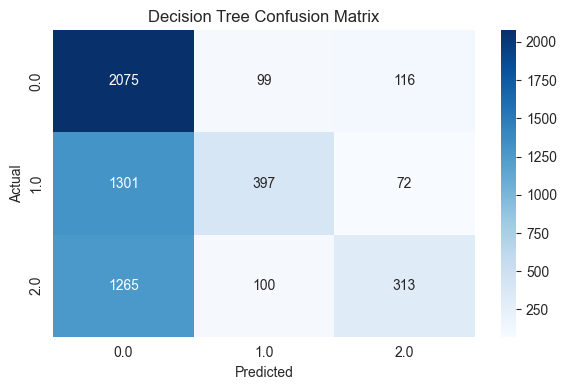

Top 10 Words per Topic from LDA Model:
+-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                |termWeights                                                                                                                                                                                                                         |
+-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[2687, 1040, 1343, 383, 1328, 3380, 1389, 2733, 358, 3081] |[0.

In [38]:
# Claudine
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluation: Decision Tree

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print("Decision Tree Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix Plot
conf_matrix_df = dt_predictions.select("label", "prediction").toPandas()

# Convert label numbers to string if needed (Optional)
confusion_matrix = pd.crosstab(conf_matrix_df["label"], conf_matrix_df["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()

# Interpretation: LDA Topics
print("Top 10 Words per Topic from LDA Model:")
topics.show(truncate=False)

# Display top words for each topic using CountVectorizer's vocabulary
vocab = cv_model.vocabulary  # This gives us the actual word list

print("Top 10 Words per Topic from LDA Model:")
topic_indices = lda_model.describeTopics(10)
topic_indices_local = topic_indices.limit(3).collect()

for i, row in enumerate(topic_indices_local):
    word_indices = row['termIndices']
    words = [vocab[idx] for idx in word_indices]
    print(f"Topic {i}: {', '.join(words)}")


for i, words in enumerate(words):
    print(f"Topic {i}: {', '.join(words)}")



In [37]:
# Stage 3 – Machine Learning
# Claudine (Decision Tree & LDA)

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import LDA

# Use normalized TF-IDF vectors from Stage 2
data = tfidf_data_train.select("tfidf_norm", "author")

# Encode author names to numeric labels
label_indexer = StringIndexer(inputCol="author", outputCol="label")
data_indexed = label_indexer.fit(data).transform(data)

# Split dataset
train_data, test_data = data_indexed.randomSplit([0.7, 0.3], seed=42)

# --- Decision Tree Classifier (Supervised) ---
dt = DecisionTreeClassifier(
    featuresCol="tfidf_norm",
    labelCol="label",
    maxDepth=18,               # try higher depth
    minInstancesPerNode=2,     # allow splits with fewer samples
    #impurity="gini"            # default is fine, but you can also test "entropy"
)

dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# --- LDA (Unsupervised Topic Modeling) ---
lda = LDA(k=5, seed=42, featuresCol="tfidf_norm")  # 5 topics for deeper separation
lda_model = lda.fit(tfidf_data_train)

# Show top 10 words per topic
topics = lda_model.describeTopics(10)
topics.show(truncate=False)


+-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                |termWeights                                                                                                                                                                                                                         |
+-----+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[2687, 1040, 1343, 383, 1328, 3380, 1389, 2733, 358, 3081] |[0.002564816702024404, 0.00240537028813296

In [ ]:
# Radhika
from pyspark.ml.evaluation import 
# ------------------------- Random Forest ----------------------
# Evaluate the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)